## **Introduction**

In **Object-Based Image Analysis (OBIA)**, the first step is to create segments—this means breaking the image down into small groups of pixels that are next to each other and have similar properties. Once we have these segments, we can classify them and adjust the groups as needed. OBIA differs from traditional pixel-based methods by focusing on these segments rather than individual pixels, which brings several advantages:
* **Smoother classifications**: Grouping similar pixels helps avoid noisy results, which can sometimes look like random scattered dots (commonly called the "salt-and-pepper effect").
* **Better object detection**: It's easier to count and analyze objects when they are represented as segments rather than individual pixels.
* **More features to describe objects**: By working with segments, we can use extra information, such as shape and texture, to better describe the objects.
* **Improved performance**: Fewer individual observations are needed, which speeds up the processing.

There are various methods to create these segments in OBIA. In this notebook, we will explore Threshold-based and Cluster-based segmentation methods.



## **Setup**

Please run the cell below. After that, go to **Runtime -> Restart session**, and confirm. Once the session restarts, move on to the next cell **without running this one again**.

In [ ]:
# Check if running on Google Colab
if 'google.colab' in str(get_ipython()):
    import os
    repo_dir = "obia_tutorials"
    marker_file = os.path.join(repo_dir, ".setup_done")

    # Setup the environment only if it hasn't been done already
    if not os.path.exists(marker_file):
        # Clone the repository
        !git clone https://github.com/mariarodriguezn/obia_tutorials.git

        # Install the required packages
        !pip install -r obia_tutorials/requirements.txt

        # Create a marker file to avoid re-running the setup
        with open(marker_file, 'w') as f:
            f.write("Setup completed")

In [ ]:
# Imports
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage
import rasterio

from matplotlib import rcParams
from skimage import util
from skimage.segmentation import mark_boundaries, slic
from tqdm import tqdm

# Set general figsize
rcParams['figure.figsize'] = (7.5, 7.5)

## **Exemplary data**

For demonstration purposes, we will use an image that contains four bands: Red, Green, Blue, and Near-Infrared (NIR). Additionally, we will create two single-band grayscale images. The first image will show the average reflectance across the RGB bands, while the second image will represent the Normalized Difference Vegetation Index (NDVI).

####**Task 1**
Using the same approach used for visualizing the RGB image below, plot:


*   The Average RGB Reflectance with a colormap of "gray"
*   The NDVI with a colormap of "RdYlGn"

Hint: Use '*cmap*' parameter for colormap.

Make sure all three plots (Original RGB, Average RGB Reflectance, and NDVI) are displayed side by side in the same figure.

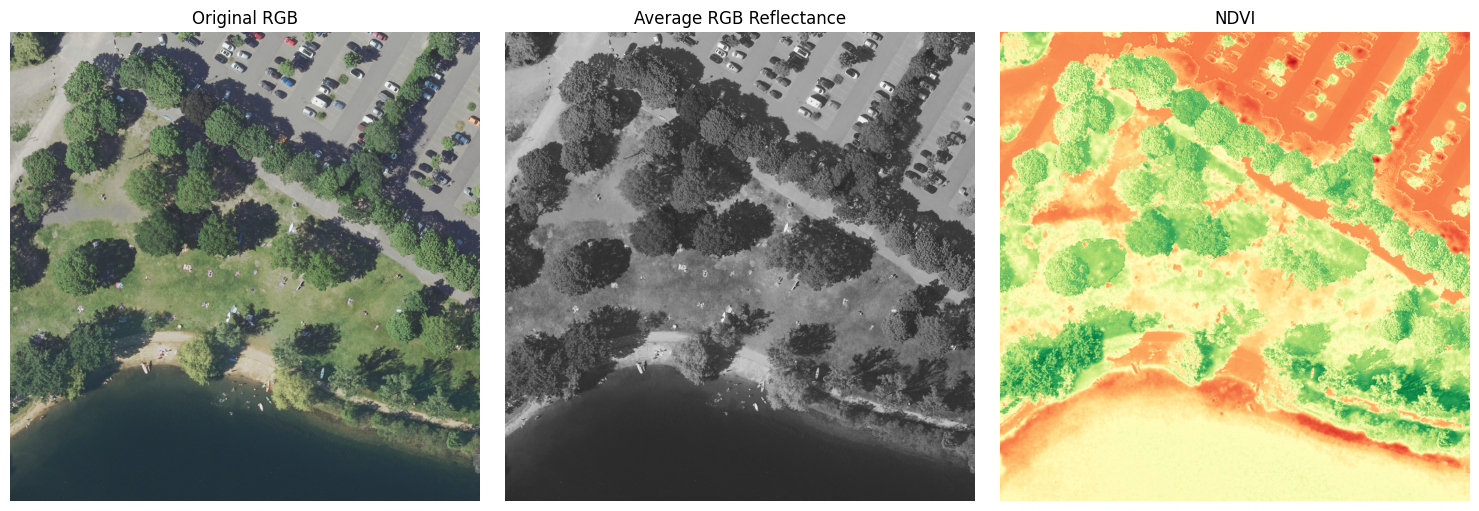

In [7]:
# File path to the image
img_path = "obia_tutorials/sample_data/ortho_subset_I.tif"

# Read the image and extract the bands
with rasterio.open(img_path) as src:
    # Extract red, green, blue, and NIR bands, normalize to [0, 1]
    bands = src.read([1, 2, 3, 4]).astype(float) / 255
    red, green, blue, nir = bands

# Stack RGB into an array and calculate average reflectance
rgb = np.stack([red, green, blue], axis=-1)
rgb_mean_reflectance = np.mean(rgb, axis=2)

# Calculate NDVI
ndvi = (nir - red) / (nir + red + 1e-6)  # small value added to avoid division by zero

# Create the figure for subplots
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

# RGB plot
axs[0].imshow(rgb)
axs[0].set_title("Original RGB")
axs[0].axis("off")

#### Your code here to plot the Average RGB Reflectance ####
axs[1].imshow(rgb_mean_reflectance, cmap="gray")
axs[1].set_title("Average RGB Reflectance")
axs[1].axis("off")

#### Your code here to plot the NDVI Plot ####
axs[2].imshow(ndvi, cmap="RdYlGn")
axs[2].set_title("NDVI")
axs[2].axis("off")

plt.tight_layout()
plt.show()

## **Methods**

### **A. Threshold-based segmentation**

#### **A.1 Manual, supervised thresholding**

Let’s begin with a simple method to create regions: **thresholding**. By selecting one or more threshold values, we can separate regions based on the intensity of the pixels. In this case, we’ll use this method to distinguish between vegetated and non-vegetated areas by applying an NDVI threshold.

#####**Task 2**

*   Populate the **'thresholds'** array with at least two (2) different NDVI threshold values you would like to evaluate.
*   Visualize the resulting binary images for different thresholds, and answer: **Which NDVI threshold best differentiates between vegetated and unvegetated regions?**


**Answer** \\
The threshold values I used are [0.2, 0.4, 0.6]. These values were taken from [MathWorks](https://www.mathworks.com/help/images/identify-vegetation-regions-using-interactive-ndvi-thresholding.html) where 0.2 represents sparse vegetation, 0.4 represents moderate vegetation, and 0.6 represents dense vegetation. Based on the accompanying results, the 0.4 NDVI threshold best differentiates between vegetated and unvegetated regions. The 0.2 threshold includes too many non-vegetated areas and misclassifies some of the water as vegetation, whereas the 0.6 threshold excludes a lot of vegetated areas.

**You answer goes here:**

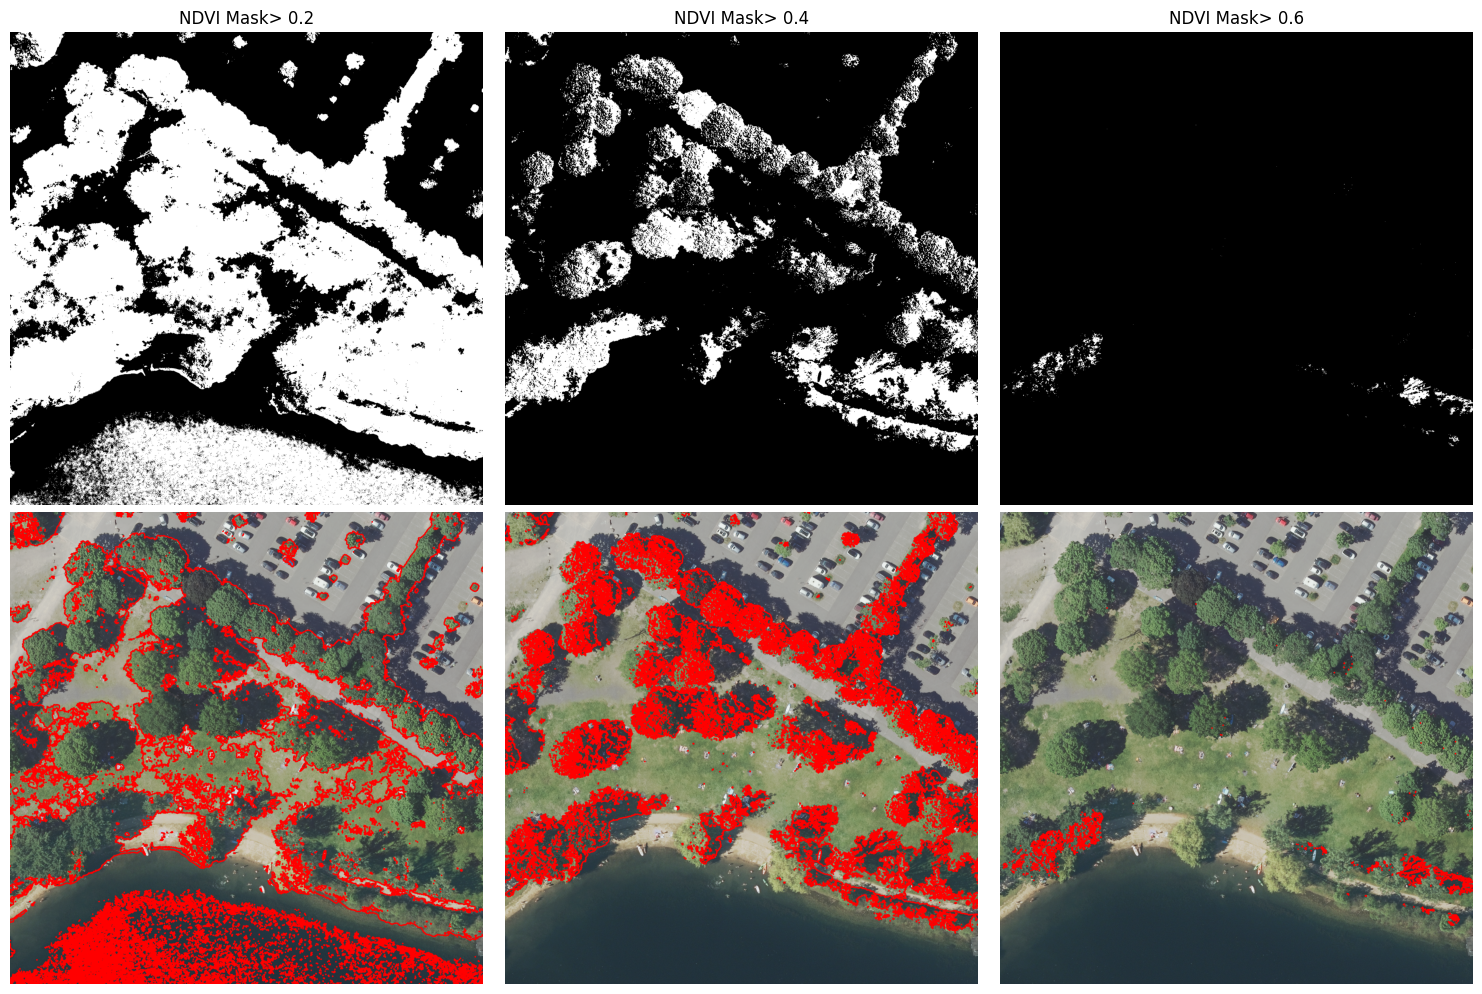

In [8]:
#### Your code here to define 2 or more different threshold to try ####
thresholds = [0.2, 0.4, 0.6]

# Create the figure for the subplots
fig, axs = plt.subplots(
    ncols=len(thresholds),
    nrows=2,
    figsize=(5 * len(thresholds), 10)
)

# Loop through each threshold to create masks and plot them
for i, threshold in enumerate(thresholds):
    # Create a binary mask where NDVI is greater than the threshold
    mask = ndvi > threshold

    # Plot the mask (binary image where NDVI > threshold)
    axs[0, i].imshow(mask, cmap="gray")
    axs[0, i].set_title(f"NDVI Mask> {threshold}")
    axs[0, i].axis("off")

    # Plot the RGB image with boundaries marked around the NDVI mask
    axs[1, i].imshow(mark_boundaries(rgb, mask, color=(1,0,0), outline_color=(1,0,0), mode="thick")) # Define boundary plotting settings
    axs[1, i].axis("off")

# Display the plots
plt.tight_layout()
plt.show()

Based on the experiments above, you will have noticed that a threshold between **0.1** and **0.3** works best for distinguishing between vegetated and non-vegetated areas. This aligns with what we know about how the NDVI works as a spectral index. Typically, positive values above 0.2 (a commonly used threshold) suggest the presence of a strong 'red edge' in the spectral profile, which is a key indicator of photosynthetically active plants.

#### **A.2 Automated, unsupervised thresholding**

Choosing the right threshold is not always straightforward. To help with this, there are several unsupervised methods that can automatically determine a suitable threshold.

Most of these methods work by analyzing the histogram of the pixel intensities to set the threshold without needing any input. However, the effectiveness of these unsupervised methods depends heavily on the content of the image. While the output thresholds may work well for the input image, their transferability to other images needs to be carefully evaluated before use.

To better understand how unsupervised methods work, we will focus on one of the most popular approaches: **Otsu thresholding**.

##### **A.2.1 Otsu thresholding**

**Otsu thresholding** is a method used to automatically divide an image's pixels into two categories: **foreground** and **background**. The goal of this method is to find the best threshold that separates the image into these two distinct classes.

The method works by simultaneously maximizing **between-class variance**, which ensures that the two groups (foreground and background) are as distinct as possible, and minimizing **intra-class variance**, which reduces the variation within each group, making the pixels in each class as similar as possible. The algorithm evaluates different possible thresholds and selects the one that achieves the best balance between these two criteria.


The between-class variance $\sigma_b^2(t)$ is given by:
\begin{equation}
\sigma_b^2(t) = \omega_1(t) \omega_2(t) \left[ \mu_1(t) - \mu_2(t) \right]^2
\end{equation}
where...  
$\omega_1(t)$ is the proportion (or probability) of pixels that belong to class 1. Class 1 includes all the pixels with intensity levels from 0 to $t$,   
$\omega_2(t)$ is the proportion (or probability) of pixels that belong to class 2. Class 2 includes all the pixels with intensity levels from $t+1$ to $L-1$,   
$\mu_1(t)$ is the **average intensity** of the pixels in class 1,  
$\mu_2(t)$ is the **average intensity** of the pixels in class 2.

In [ ]:
# Get Otsu threshold for NDVI
threshold = skimage.filters.threshold_otsu(ndvi)

# Create a figure for the subplots
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

# Plot NDVI histogram with the threshold marked
axs[0].hist(ndvi.ravel(), bins=100, color="gray")
axs[0].axvline(threshold, color="red", linestyle="--")
axs[0].set_title("NDVI Histogram")

# Plot the NDVI mask (binary image where NDVI > threshold)
mask = ndvi > threshold
axs[1].imshow(mask, cmap="gray")
axs[1].set_title(f"NDVI Mask > {threshold:.2f}")
axs[1].axis("off")

# Plot the RGB image with boundaries marked around the NDVI mask
axs[2].imshow(mark_boundaries(rgb, mask, color=(1,0,0), outline_color=(1,0,0), mode="thick"))
axs[2].set_title("RGB with boundaries")
axs[2].axis("off")

# Display the plots
plt.tight_layout()
plt.show()

Due to the strong contrast between the spectral properties of vegetated and non-vegetated areas in the scene, the threshold determined by Otsu’s method aligns well with the range of suitable thresholds found in the manual approach earlier.

However, when looking at the histogram of NDVI values for this case, the intensity distribution appears to have three peaks rather than just two (trimodal instead of bimodal). Fortunately, Otsu’s method can be extended for multilevel thresholding.

######**Task 3**

*   Get multiple thresholds using Otsu’s method for the NDVI, dividing it into three (3) classes. Hint: The number of classes can be set using the `classes` parameter in the `threshold_multiotsu` method.
*   Visualize the NDVI histogram with the thresholds marked and answer the following question: **Which three classes do you think the algorithm detected or divided the image into?**

**You answer goes here:**

In [ ]:
#### Your code here to define multiple thresholds using Otsu's method ####
thresholds =

# Create a figure for the subplots
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

# Plot NDVI histogram with thresholds marked
axs[0].hist(ndvi.ravel(), bins=100, color="gray")  # Plot the histogram
for threshold, color in zip(thresholds, ["red", "orange"]):  # Mark thresholds on histogram
    axs[0].axvline(threshold, color=color, linestyle="--")
axs[0].set_title("NDVI Histogram")

# Plot binary masks (where NDVI is greater than each threshold)
mask_1 = ndvi > thresholds[0]  # Mask for the first threshold
mask_2 = ndvi > thresholds[1]  # Mask for the second threshold
axs[1].imshow(mask_1, cmap="gray", alpha=0.5)
axs[1].imshow(mask_2, cmap="gray", alpha=0.5)
axs[1].set_title(f"NDVI Mask Thresholds: {thresholds[0]:.2f}, {thresholds[1]:.2f}")
axs[1].axis("off")

# Plot RGB image with boundaries around the NDVI masks
rgb_with_boundaries_1 = mark_boundaries(rgb, mask_1, color=(1, 0, 0), outline_color=(1, 0, 0), mode="thick")
rgb_with_boundaries_2 = mark_boundaries(rgb, mask_2, color=(1, 0.5, 0), outline_color=(1, 0.5, 0), mode="thick")
axs[2].imshow(rgb_with_boundaries_1, alpha=0.5)
axs[2].imshow(rgb_with_boundaries_2, alpha=0.5)
axs[2].axis("off")

# Display the plots
plt.tight_layout()
plt.show()


#### **A.3 Postprocessing & Result exploration**

A significant limitation of the threshold-based methods is that they operate at the pixel level and do not take into account the surrounding spatial context, such as the intensity levels of neighboring pixels. Because of this, they do not fully meet the requirement of spatial contiguity and, strictly speaking, should not be considered true segmentation methods.

One way to introduce spatial consistency to these threshold-based methods is by applying filter-based postprocessing, such as a **median filter**, which reduces noise and artifacts. A median filter is a non-linear filter that calculates the median value within a local area, for example, a square neighborhood like a 3x3 kernel.

To demonstrate the effect of this filter, we will use the segmentation result from the Otsu method and apply a filter with a kernel size of 10x10 pixels, which corresponds to an area of 1m<sup>2</sup> for the given scene.

It is always advisable to explore your results not only by plotting the contours of the segments but also by visualizing the segments themselves with arbitrary colors.

In [ ]:
# Function to create a random colormap
def get_random_cmap(num_colors, base_cmap="Spectral"):
    # Get base colormap
    base_cmap = plt.get_cmap(base_cmap)
    # Randomly choose colors from the colormap
    random_colors = [base_cmap(i) for i in np.random.choice(range(base_cmap.N), num_colors)]
    # Create a colormap with those random colors
    return mcolors.ListedColormap(random_colors)

In [ ]:
# Get Otsu threshold for NDVI and create mask (binary image where NDVI > threshold)
threshold = skimage.filters.threshold_otsu(ndvi)
mask = ndvi > threshold

# Apply a median filter to the mask using a square structuring element of size 10
structuring_element = skimage.morphology.square(10)
filtered_mask = skimage.filters.median(mask, structuring_element)

# Create a figure for subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Data for plotting
masks = [mask, filtered_mask]
titles = ["Initial NDVI Mask", "NDVI Mask after median filter"]

for i in range(2):
    # Plot the masks
    axs[i, 0].imshow(masks[i], cmap="gray")
    axs[i, 0].set_title(titles[i])
    axs[i, 0].axis("off")

    # Plot the RGB image with boundaries from the masks
    rgb_with_boundaries = mark_boundaries(rgb, masks[i], color=(1, 0, 0), outline_color=(1, 0, 0), mode="thick")
    axs[i, 1].imshow(rgb_with_boundaries)
    axs[i, 1].set_title(f"RGB with boundaries of {titles[i]}")
    axs[i, 1].axis("off")

    # Label and plot segments from the masks
    labeled_segments = skimage.measure.label(masks[i].astype("int"), background=-1)
    n_segments = len(np.unique(labeled_segments))
    axs[i, 2].imshow(labeled_segments, cmap=get_random_cmap(n_segments),interpolation="nearest")
    axs[i, 2].set_title(f"Resulting Segments: {n_segments}")
    axs[i, 2].axis("off")

# Display the plots
plt.tight_layout()
plt.show()

When examining the results more closely, you can observe the effects of the **median filter**, which reduces all types of noise. Unlike some other postprocessing methods, the median filter operates across both low-intensity (black) and high-intensity (white) noise, smoothing the image while preserving edges

Depending on the specific needs of your application, adjusting the size and shape of the filter's kernel can help refine the results further

It's important to keep in mind that the thresholding followed by postprocessing is always a two-step process, where spatial context is only considered in the second stage. This limitation inherently affects the final results. As seen in the examples above, this is evident when observing the poorly formed region that combines water, beach, and meadow.

### **B. Cluster-based segmentation**


Cluster-based methods available in the **skimage** library **include  Simple Linear Iterative Clustering** ([**SLIC**](https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.slic)) for generating superpixels.

#### **B.1 Simple Linear Iterative Clustering (SLIC)**
SLIC is a segmentation algorithm that divides an image into compact, nearly uniform segments called *superpixels*. These superpixels are groups of pixels with similar color or intensity values, which generally align with the boundaries of objects in the image. SLIC is popular because it is efficient and produces visually coherent segments. The algorithm clusters pixels based on both their spatial proximity and color similarity, using the k-means algorithm to group them into superpixels.

**Key Parameters:**
* **Number of Superpixels:**  Controls how many segments are created in the image. Fewer superpixels result in larger segments, while more superpixels produce smaller, more detailed segments.
* **Compactness:** Adjusts the balance between color similarity and spatial proximity. Higher values produce more compact, evenly spaced superpixels, while lower values allow for more irregular shapes that better capture color variations

Unlike thresholding methods, SLIC can be applied to the entire stack of four bands (R, G, B, NIR).

######**Task 4**

*   Experiment with the Simple Linear Iterative Clustering (SLIC) algorithm by varying the number of superpixels. Try at least **three different values** (e.g., 5, 100, 3000) and observe how the segmentation results change.
*   After experimenting with different values, discuss **what do you observe about the size and shape of the segments**

**You answer goes here:**

In [ ]:
# Stack RGB into an array and calculate average reflectance
image = np.stack([red, green, blue, nir], axis=-1)

# Fixed compactness
compactness = 0.3

#### Your code here to define different numbers of superpixels to try ####
n_segments_list = []

# Create the figure for the subplots
fig, axs = plt.subplots(nrows=1, ncols=len(n_segments_list), figsize=(15, 5))

# Loop through different numbers of segments
for i, n_seg in enumerate(n_segments_list):
    segments = slic(image, n_segments=n_seg, compactness=compactness, start_label=1)

    # Display RGB image with superpixel boundaries
    axs[i].imshow(mark_boundaries(rgb, segments, color=(1, 0, 0), mode="thick"))
    axs[i].set_title(f'n_segments: {n_seg}')
    axs[i].axis('off')

plt.tight_layout()
plt.show()

In the previous cell, the number of superpixels was changed while keeping the compactness constant. This allowed us to see how different segment sizes affect the image. In the case of the example values:

*   **At very few superpixels (e.g., 5)**: The image is broken into large, simple segments, which results in a very coarse division that misses many finer details.

*   **At a moderate number of superpixels (e.g., 100)**: The image is divided into smaller segments that more closely match object boundaries, though some small details are still missed.

*   **At a very high number of superpixels (e.g., 3000)**: The image is divided into many tiny superpixels, capturing subtle variations in color and texture. At this level, it's easier to identify specific objects like trees and their shadows.

######**Task 5**

*   Experiment with the SLIC algorithm by varying the compactness values while keeping the number of superpixels fixed. Try at least three different values (e.g., 0.1, 1, 100) and observe how they affect the shape and arrangement of superpixels.
*   After experimenting with different values, discuss **what do you observe about the segmentation, focusing on how compactness affects the results.**

**You answer goes here:**

In [ ]:
# Fixed number of superpixels
n_segments = 1000

#### Your code here to define different compactness values to try ####
compactness_list = []

# Create the figure for the subplots
fig, axs = plt.subplots(nrows=1, ncols=len(compactness_list), figsize=(15, 5))

# Loop through different compactness values
for i, comp in enumerate(compactness_list):
    segments = slic(image, n_segments=n_segments, compactness=comp, start_label=1)
    axs[i].imshow(mark_boundaries(rgb, segments, color=(1, 0, 0), outline_color=(1, 0, 0), mode="thick"))
    axs[i].set_title(f'compactness: {comp}')
    axs[i].axis('off')

plt.tight_layout()
plt.show()

In the previous cell, the number of superpixels was kept fixed at 1000, while the compactness was varied. This allowed us to observe how changes in compactness affect the shape and structure of the superpixels:

*   **With very low compactness (e.g., 0.1):** The superpixels closely follow color boundaries, resulting in very irregular shapes that adapt strongly to local color variations.

*   **With moderate compactness (e.g., 1):** The superpixels achieve a balance between color sensitivity and spatial regularity, meaning they still follow color boundaries but with more consistent shapes.

*   **With very high compactness (e.g., 100):** The superpixels become almost square and regular, with less emphasis on the image content and more focus on maintaining uniformity in shape.






### **C. Others**

#### **C.1 Region-based**

Region-based methods rely on a homogeneity criterion, assuming that pixels within a segment have similar intensity values. These methods can be divided into two main categories:

* **Bottom-up region growing algorithms,** which start from small initial areas (called seeds) and expand by adding neighboring pixels to form larger regions.
  * [**Watershed segmentation**](**https://svi.nl/watershed**): Watershed segmentation is a technique inspired by how water naturally flows in a landscape, where brighter regions of an image are treated as "high elevations" and darker regions as "valleys." The algorithm starts by placing "seed points" in the valleys (low-intensity areas) and simulates water spreading out from these seeds.
  
   As the water rises, it meets water from other seeds, and these meeting points form the boundaries of segments. This method is particularly effective for separating objects that are touching or overlapping, as it accurately delineates the boundaries between them based on the intensity variations in the image.
  <div style="text-align: right;">
  <img src="https://www.researchgate.net/publication/349323744/figure/fig2/AS:991524607258625@1613409296245/The-segmentation-process-of-the-watershed-algorithm.ppm">
  </div>
* **Top-down region splitting algorithms**, which begin with a large initial region and iteratively split it into smaller segments.
  * [**Quadtree segmentation**](https://www.sciencedirect.com/science/article/abs/pii/0031320385900512): This method divides an image into four equal quadrants, recursively splitting regions that are not homogeneous. It’s particularly useful for hierarchical image processing and data compression.
  <div style="text-align: right;">
  <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRRGOWrBoGFrqslLrCcImm-lWNP4RsH2ObKnA&s" width="400" height="200">
  </div>
  <div style="text-align: right;">
  <img src="https://d3i71xaburhd42.cloudfront.net/9f086ab1048f519384712c59a9a4d8f14b652c50/2-Figure1-1.png" width="400" height="200">
  </div>


#### **C.2 Neural-network based segmentation**

Neural network (NN)-based segmentation is a broad field that includes various approaches such as semantic segmentation, instance segmentation, and panoptic segmentation. In the context of deep learning, semantic segmentation refers to pixel-level labeling, while instance and panoptic segmentation are used to delineate distinct, spatially contiguous regions. NN-based models use a series of non-linear functions to analyze both image intensity and spatial context, learning from large sets of annotated training images to segment new images in a supervised, data-driven manner. Once trained, these models can be applied in an unsupervised manner without needing parameter adjustments.

A notable approach released in 2023 is Segment Anything (SAM), which enables instance segmentation with minimal input (zero-/few-shot learning). SAM is built on a vision transformer architecture and has been trained on over 11 million images across multiple domains, making it a "foundation model" with strong generalization abilities, even in previously unseen domains like remote sensing imagery. Although SAM is not demonstrated in this notebook due to its complexity and GPU requirements, you can explore it using the [segment-geospatial](https://samgeo.gishub.org/installation/) package.

## **Conclusion & Further thoughts**

This notebook has introduced a variety of segmentation algorithms, organized by their methodological domains (e.g., threshold-based, cluster-based, region-based). The goal is to help you understand the fundamentals of segmentation methods and their differences. From a practical perspective, consider the following questions when choosing a segmentation approach:
* What are the characteristics of the segmentation results?
* What parameter options does the algorithm provide (e.g., number of regions, shape constraints)?
* What types of input can the algorithm handle (e.g., single or multi-channel images, original vs. pre-processed images)?
* How efficient and scalable is the algorithm?

Additionally, the choice of input data (e.g., input bands, indices) is crucial for effective segmentation. Remember, Object-Based Image Analysis (OBIA) goes beyond segmentation. It involves an iterative process of segmentation and classification to refine and improve the results, as there is rarely a perfect initial segmentation.

## **References**

For further reading, you can refer to the following sources:

* [Blaschke, T., Burnett, C., & Pekkarinen, A. (2004).](https://doi.org/10.1007/978-1-4020-2560-0_12) Image Segmentation Methods for Object-based Analysis and Classification  
* [Hossain, M. D., & Chen, D. (2019).](https://linkinghub.elsevier.com/retrieve/pii/S0924271619300425) Segmentation for Object-Based Image Analysis (OBIA): A review of algorithms and challenges from remote sensing perspective  
* [Kotaridis, I., & Lazaridou, M. (2021).](https://linkinghub.elsevier.com/retrieve/pii/S0924271621000265) Remote sensing image segmentation advances: A meta-analysis